# IIAS Network Report
Query the IIAS database to summarize network traffic for your IIA System using the database collected and stored in the IIAS Database. The historical records for the IIAS System are stored in the IBM_SAILFISH Schema.

## Db2 Extensions
This tutorial relies on a Jupyter notebook extensions, commonly refer to as a "magic" commands. The beginning of all of the notebooks begin with the following command which will load the extension and allow the remainder of the notebook to use the %sql magic command.
<pre>
&#37;run db2.ipynb
</pre>
The cell below will load the Db2 extension. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook. You can find out more about the Db2 Extensions at https://github.com/DB2-Samples/db2jupyter

In [1]:
%run db2.ipynb

Pixiedust database opened successfully


DB2 Extensions Loaded.


In [2]:
# load pandas for dataframe support and numpy for statistical manipulation and matplot for graphing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connections to Db2

Before any SQL commands can be issued, a connection needs to be made to the Db2 database that you will be using. The connection can be done manually (through the use of the CONNECT command), or automatically when the first %sql command is issued.

The Db2 magic command tracks whether or not a connection has occured in the past and saves this information between notebooks and sessions. When you start up a notebook and issue a command, the program will reconnect to the database using your credentials from the last session. In the event that you have not connected before, the system will prompt you for all the information it needs to connect. This information includes:

- Database name (SAMPLE) 
- Hostname - localhost (enter an IP address if you need to connect to a remote server) 
- PORT - 50000 (this is the default but it could be different) 
- Userid - DB2INST1 
- Password - No password is provided so you have to enter a value 
- Maximum Rows - 10 lines of output are displayed when a result set is returned 

There will be default values presented in the panels that you can accept, or enter your own values. All of the information will be stored in the directory that the notebooks are stored on. Once you have entered the information, the system will attempt to connect to the database for you and then you can run all of the SQL scripts. More details on the CONNECT syntax will be found in a section below.

The next statement will force a CONNECT to occur with the default values. If you have not connected before, it will prompt you for the information.

In [3]:
%sql connect reset

Connection reset.


In [4]:
# create a persistent connection to the DSM Historical Repository Database
%sql connect to BLUDB user bluadmin using ? host 9.30.254.152 port 50000

Password [password]: ········
Connection successful.


## Retrieving historical system data from IIAS

The [ADMINTABINFO administrative view](https://www.ibm.com/support/knowledgecenter/en/SSEPGG_11.1.0/com.ibm.db2.luw.sql.rtn.doc/doc/r0052897.html)
returns size and state information for tables, materialized query tables (MQT) and hierarchy tables only. These table types are reported as T for table, S for materialized query tables and H for hierarchy tables in the SYSCAT.TABLES catalog view. The information is returned at both the data partition level and the database partition level for a table.

The query below shows you all the System Level monitoring tables available.

In [5]:
%sql -a SELECT TABNAME AS SYSTEM_MONITORING_TABLES FROM SYSCAT.TABLES WHERE TABSCHEMA = 'IBM_SAILFISH' ORDER BY TABNAME

,SYSTEM_MONITORING_TABLES
0,ALERTS_MAPPING
1,MONITORING_CPU
2,MONITORING_IO_READ
3,MONITORING_IO_WRITE
4,MONITORING_MEMORY
5,MONITORING_NETWORK_RX
6,MONITORING_NETWORK_TX
7,MONITORING_STORAGE_FILESYSTEMS
8,MONITORING_STORAGE_NODELEVEL
9,MONITORING_STORAGE_NODES


## Retrieving Data and Converting Time
The current timestamps of the collected data is stored in UNIX EPOCH format, seconds since January 1st, 1970. To convert to more useful values the statement below retrieves the database from the warehouse database and constructs several columns that can be used to group and classify data later. The results are automatically streamed into a new Data Frame called NetworkTX.

In [16]:
NetworkTX = %sql \
SELECT TIME(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIME_COLLECTED, \
    HOUR(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS HOUR_COLLECTED, \
    DATE(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS DATE_COLLECTED, \
    (TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIMESTAMP_COLLECTED, \
    TS AS EPOCH_TIME, \
    "MIN_VAL" AS MIN_KBS, \
    "AVG_VAL" AS AVG_KBS, \
    "MAX_VAL" AS MAX_KBS, \
    "MASTER_VAL" AS MASTER_KBS \
    FROM "IBM_SAILFISH"."MONITORING_NETWORK_TX"; 
NetworkTX.head()

,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,MIN_KBS,AVG_KBS,MAX_KBS,MASTER_KBS
0,07:35:29,7,2018-05-08,2018-05-08 07:35:29,1525764929360,3.28,15.21,27.15,13.19
1,07:36:34,7,2018-05-08,2018-05-08 07:36:34,1525764994182,3.14,4.21,5.28,31.71
2,07:37:36,7,2018-05-08,2018-05-08 07:37:36,1525765056375,20.51,27.43,34.34,19.26
3,07:38:36,7,2018-05-08,2018-05-08 07:38:36,1525765116745,6.13,15.38,24.64,31.95
4,07:39:45,7,2018-05-08,2018-05-08 07:39:45,1525765185921,3.08,39.01,74.94,10.13


In [15]:
NetworkRX = %sql \
SELECT TIME(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIME_COLLECTED, \
    HOUR(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS HOUR_COLLECTED, \
    DATE(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS DATE_COLLECTED, \
    (TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIMESTAMP_COLLECTED, \
    TS AS EPOCH_TIME, \
    "MIN_VAL" AS MIN_KBS, \
    "AVG_VAL" AS AVG_KBS, \
    "MAX_VAL" AS MAX_KBS, \
    "MASTER_VAL" AS MASTER_KBS \
    FROM "IBM_SAILFISH"."MONITORING_NETWORK_RX"; 
NetworkRX.head()

,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,MIN_KBS,AVG_KBS,MAX_KBS,MASTER_KBS
0,07:35:29,7,2018-05-08,2018-05-08 07:35:29,1525764929360,2.71,14.68,26.64,14.40
1,07:36:34,7,2018-05-08,2018-05-08 07:36:34,1525764994182,2.61,3.62,4.62,166.02
2,07:37:36,7,2018-05-08,2018-05-08 07:37:36,1525765056375,20.29,27.45,34.60,12.33
3,07:38:36,7,2018-05-08,2018-05-08 07:38:36,1525765116745,6.74,14.61,22.47,27.82
4,07:39:45,7,2018-05-08,2018-05-08 07:39:45,1525765185921,2.68,34.04,65.39,9.84


## Creating a Pivot Table
With a simple single command you can use the existing dataframe to pivot the dataset by day and hour.

In [17]:
pd.pivot_table(NetworkTX,index=["DATE_COLLECTED","HOUR_COLLECTED"])

AVG_KBS    EPOCH_TIME  MASTER_KBS  \
DATE_COLLECTED HOUR_COLLECTED                                         
2018-05-08     7               488.609167  1.525766e+12   67.852083   
               8               143.520826  1.525768e+12   33.285688   
               9                52.523478  1.525772e+12  135.317217   
               10               73.108017  1.525775e+12   44.537155   
               11               41.603793  1.525779e+12   55.685690   
...                                   ...           ...         ...   
2018-05-30     5                60.158276  1.527658e+12  251.198448   
               6               100.092105  1.527662e+12  122.326491   
               7                58.048276  1.527665e+12  244.376897   
               8               393.357455  1.527669e+12   63.018545   
               9                19.557727  1.527672e+12  108.182727   

                                  MAX_KBS    MIN_KBS  
DATE_COLLECTED HOUR_COLLECTED                         
2018-05-08     7               921.173750  56.042917  
               8               270.727339  16.314128  
               9                86.973652  18.072087  
               10              126.705172  19.510776  
               11               68.253534  14.952931  
...                                   ...        ...  
2018-05-30     5                97.742414  22.574655  
               6               186.028246  14.154561  
               7               104.629828  11.467759  
               8               769.631455  17.084182  
               9                25.930000  13.183636  

[206 rows x 5 columns]

## Graphing Receive and Transmit Volumes
So see the full dataset more easily you can graph both send and receive volumns.

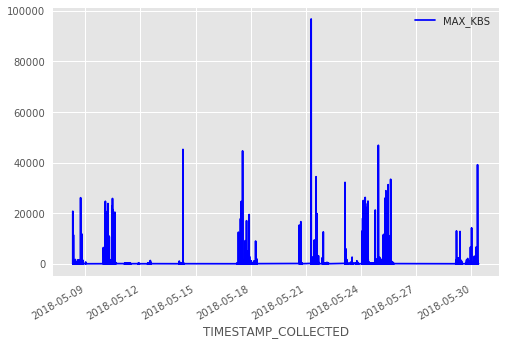

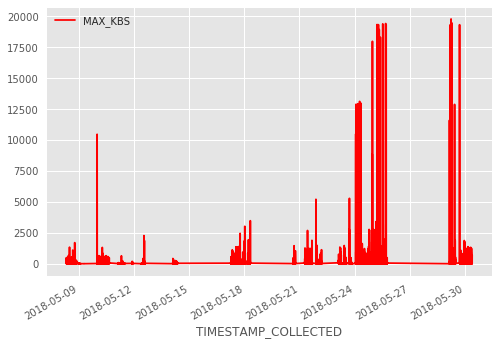

In [18]:
NetworkTX.plot(x='TIMESTAMP_COLLECTED', y='MAX_KBS', color='b')
NetworkRX.plot(x='TIMESTAMP_COLLECTED', y='MAX_KBS', color='r')
plt.show()

## Analyzing Time of Day Distributions
A simple scatter graph based on the HOUR_COLLECTED can show you the distribution of network traffic by the time of the day.

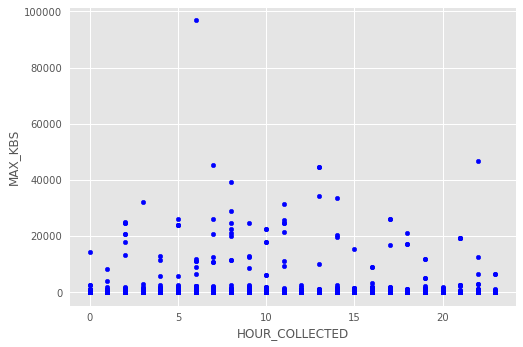

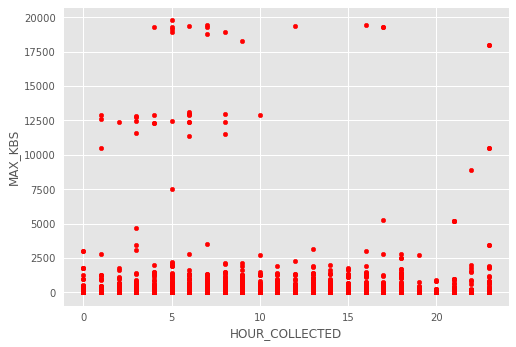

In [19]:
NetworkTX.plot.scatter(x='HOUR_COLLECTED', y='MAX_KBS', color='b')
NetworkRX.plot.scatter(x='HOUR_COLLECTED', y='MAX_KBS', color='r')
plt.show()

## Analyzing Time of Day Distributions
A simple scatter graph based on the HOUR_COLLECTED can show you the distribution of network traffic by the time of the day.

In [20]:
NetworkTX.sort_values('MAX_KBS', ascending=False).groupby("HOUR_COLLECTED").head(2)

,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,MIN_KBS,AVG_KBS,MAX_KBS,MASTER_KBS
6936,06:54:30,6,2018-05-21,2018-05-21 06:54:30,1526885670350,11.67,48413.62,96815.57,255.30
9591,22:38:03,22,2018-05-24,2018-05-24 22:38:03,1527201483475,4.02,23428.29,46852.57,13.81
4894,07:31:15,7,2018-05-14,2018-05-14 07:31:15,1526283075694,9.57,22615.45,45221.33,96.58
5930,13:22:13,13,2018-05-17,2018-05-17 13:22:13,1526563333515,30.31,22332.72,44635.14,17.47
5931,13:22:13,13,2018-05-17,2018-05-17 13:22:13,1526563333515,30.31,22332.72,44635.14,17.47
...,...,...,...,...,...,...,...,...,...
9651,00:20:42,0,2018-05-25,2018-05-25 00:20:42,1527207642923,19.35,1275.43,2531.51,4.88
9520,20:43:43,20,2018-05-24,2018-05-24 20:43:43,1527194623263,4.83,913.74,1822.64,15.03
10622,12:08:09,12,2018-05-25,2018-05-25 12:08:09,1527250089141,14.25,891.55,1768.85,1090.49
1435,15:56:52,15,2018-05-08,2018-05-08 15:56:52,1525795012637,7.19,798.64,1590.09,104.48


## Find the Peak Network Volumes by Hour
Another single statement can sort and group values by the hour collected. head(2) returns the top two values for each hour of the day

In [12]:
NetworkRX.sort_values('MAX_VAL', ascending=False).groupby("HOUR_COLLECTED").head(2)

,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,MIN_VAL,AVG_VAL,MAX_VAL,MASTER_VAL
11144,05:55:01,5,2018-05-29,2018-05-29 05:55:01,1527573301924,4.44,9892.68,19780.93,75.27
10673,07:11:36,7,2018-05-29,2018-05-29 07:11:36,1527577896837,5.65,9728.02,19450.38,93.31
10547,16:29:21,16,2018-05-25,2018-05-25 16:29:21,1527265761806,8.91,9710.62,19412.33,1573.21
10640,06:36:58,6,2018-05-29,2018-05-29 06:36:58,1527575818622,9.01,9697.55,19386.08,23.58
10333,12:43:37,12,2018-05-25,2018-05-25 12:43:37,1527252217150,10.10,9696.52,19382.94,70.48
...,...,...,...,...,...,...,...,...,...
10407,14:03:00,14,2018-05-25,2018-05-25 14:03:00,1527256980073,53.70,824.68,1595.65,14.61
9934,11:23:22,11,2018-05-25,2018-05-25 11:23:22,1527247402198,16.29,720.32,1424.36,245.55
10163,20:43:43,20,2018-05-24,2018-05-24 20:43:43,1527194623263,11.62,461.43,911.23,23.07
11313,20:42:54,20,2018-05-29,2018-05-29 20:42:54,1527626574579,24.81,420.83,816.86,14.26


## Understanding distribution of Network Traffic
Boxplots let you discard the outliers from your analysis and look at the bulk of the network traffic data. The chart below shows the median, first and third quartile as well as the statistical minimum and maximum values. Outliers are identified with a symbol defined by "sym=". The symbol is left blank if you want to ignore outlyer data and focus on the statistically relavent datapoints.

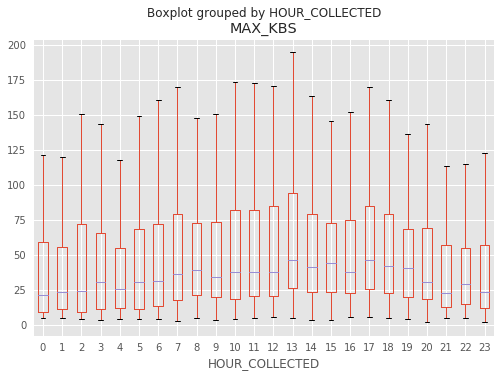

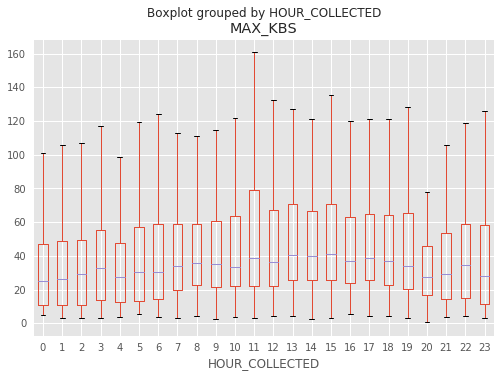

In [21]:
NetworkTX.boxplot('MAX_KBS', by='HOUR_COLLECTED', sym='')
NetworkRX.boxplot('MAX_KBS', by='HOUR_COLLECTED', sym='')
plt.show()